# Notebook Demo for A2H Recommendation System

This is a simple demonstration of how our proposed A2H recommendation system works. A web-based version of the system is currently under development. Please stay tuned for updates!

## Use case scenario

The proposed recommendation system aims to allow drug development scientists to find high-quality preclinical trials that are more likely to translate outcomes to the desired clinical trial experiments. This way, the scientists can optimize preclinical trials, which would be much cheaper compared to human trials, instead of prematurely entering and failing clinical trials. The proposed recommendation system would work as follows. A user would provide partial or whole clinical trial experimental settings or interest. The recommendation system will then generate the recommended preclinical experiment settings, ranked based on the translation success probability predicted by our trained ML model, along with explanations for the predictions. For each recommended preclinical trial setting, the system would also provide the range of differences between preclinical and clinical outcomes, defined by different thresholds for δ. For example, if the threshold is 10%, then the preclinical and clinical outcomes differ by no more than 10%. Lastly, the user scientist would perform the recommended preclinical trial and collect the preclinical outcome. If the preclinical outcome is 50%, the predicted clinical outcome will be 40-60% given the 10% difference range.

## Preparation


In [1]:
# Importing the libraries.
import os
import sys
import pickle
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd

from src.utils import load_splits, load_best_pipeline, get_simple_pipeline
from src.utils import constants

In [2]:
# Load and train the production model.
path_data_dir = "../outputs/data_processing/splits/cls_delta-0.5_rs-42"
path_cls_dir = "../outputs/msap/cls_delta-0.5_rs-42"

data_train, data_test, _ = load_splits(path_data_dir)
model = load_best_pipeline(path_cls_dir)
with open(f"{path_cls_dir}/classifiers/sfs.pkl", 'rb') as f:
    sfs = pickle.load(f)

data = pd.concat([data_train, data_test], axis=0)
inputs = data_train.drop('result translation', axis=1)
labels = data_train['result translation']

prep_pipeline = get_simple_pipeline(inputs, constants.FEATURES_CAT)
prep_pipeline.fit(inputs)
inputs = prep_pipeline.transform(inputs)
inputs = inputs[list(sfs.k_feature_names_)]

model.fit(inputs, labels)
model = model.named_steps['cls']

print("Model trained successfully.")


/mnt/share/fzli/.conda/envs/a2h/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Model trained successfully.


## Recommendation

The following example shows the scenario where a user provides the following clinical trial settings:
- Endpoint: Acute
- Dosage times per day: 2
- Age group: Not child

In [3]:
# Create candidate inputs for the model.
from itertools import product

feature_value_ranges = {
    'ohe_0__acute/sustained preclinical_sustained': [0, 1],
    'ohe_1__gnotobiotic preclinical_spf': [0, 1],
    'ohe_2__animal strain preclinical_c57bl/6j': [0, 1],
    'scaler_4__animal age value (days) preclinical': [5, 10, 20, 40],
    'scaler_5__animal weight value (g) preclinical': [70, 140, 280, 560],
    'ohe_7__disease model preclinical_kanamycin,gentamicin,colistin,metronidazole,vancomycin+clindamycin+challenge': [0, 1],
    'ohe_8__prophylactic / therapeutic preclinical_t': [0, 1],
    'ohe_9__ribotype preclinical_1.0': [0, 1],
    'scaler_11__c diff dose value preclinical': [100, 1000, 10000, 100000, 1000000],
    'scaler_14__daily dosage preclinical': [None],
    'scaler_16__dosage value preclinical': [5, 10, 20, 40, 80, 160],
    'scaler_17__dosage times per day preclinical': [1, 2],
    'scaler_18__dosage duration preclinical': [1, 3, 5, 7],
    'ohe_19__acute/sustained clinical_sustained': [0],
    'scaler_23__dosage times per day clinical': [2],
    'ohe_26__Age Groups clinical_child': [0],
}

candidates = pd.DataFrame(
    list(product(*feature_value_ranges.values())),
    columns=feature_value_ranges.keys(),
)
candidates['scaler_14__daily dosage preclinical'] = candidates['scaler_16__dosage value preclinical'] * candidates['scaler_17__dosage times per day preclinical']
candidates['translation_success_prob'] = model.predict_proba(candidates)[:, 1]

In [24]:
# According to the model, the top 5 candidates are:
candidates = candidates.sort_values('translation_success_prob', ascending=False)
candidates.head(5)

,ohe_0__acute/sustained preclinical_sustained,ohe_1__gnotobiotic preclinical_spf,ohe_2__animal strain preclinical_c57bl/6j,scaler_4__animal age value (days) preclinical,scaler_5__animal weight value (g) preclinical,"ohe_7__disease model preclinical_kanamycin,gentamicin,colistin,metronidazole,vancomycin+clindamycin+challenge",ohe_8__prophylactic / therapeutic preclinical_t,ohe_9__ribotype preclinical_1.0,scaler_11__c diff dose value preclinical,scaler_14__daily dosage preclinical,scaler_16__dosage value preclinical,scaler_17__dosage times per day preclinical,scaler_18__dosage duration preclinical,ohe_19__acute/sustained clinical_sustained,scaler_23__dosage times per day clinical,ohe_26__Age Groups clinical_child,translation_success_prob
37138,0,0,1,5,560,0,1,0,100000,80,80,1,5,0,2,0,0.923795
48658,0,0,1,20,140,0,1,0,100000,80,80,1,5,0,2,0,0.923795
42898,0,0,1,10,280,0,1,0,100000,80,80,1,5,0,2,0,0.923795
50578,0,0,1,20,280,0,1,0,100000,80,80,1,5,0,2,0,0.923795
52498,0,0,1,20,560,0,1,0,100000,80,80,1,5,0,2,0,0.923795


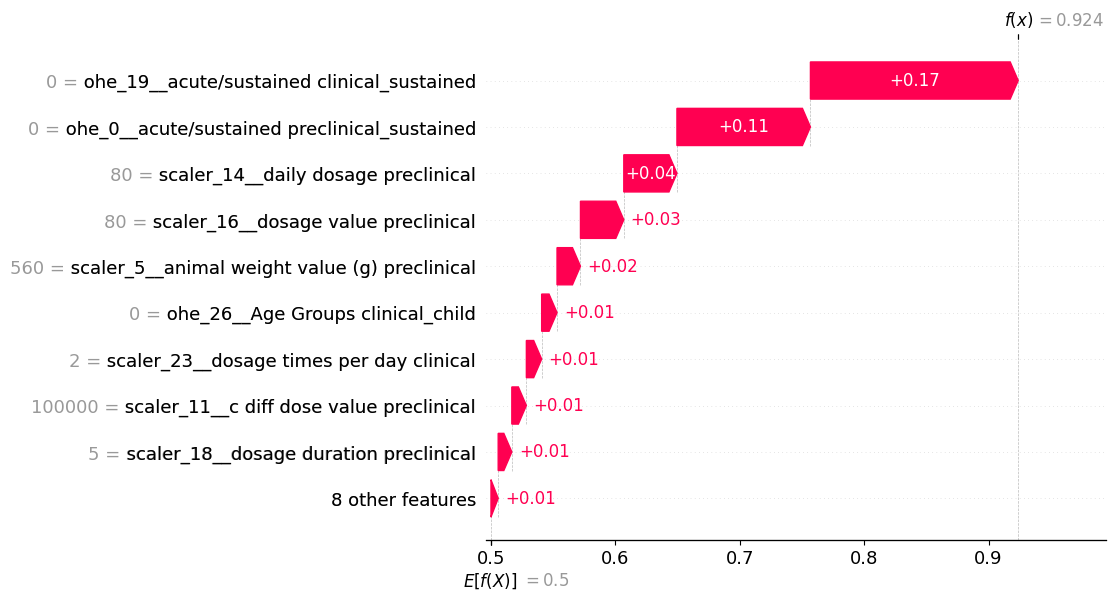

In [25]:
import numpy as np
import shap

np.random.seed(42)
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(
    candidates.iloc[
        [0] + list(np.random.choice(
            list(range(1, len(candidates) - 1)),
            1000,
            replace=False,
        )) + [len(candidates) - 1]
    ]
)

shap.plots.waterfall(shap_values[0, :, 1])

# And here is the SHAP explanation for the top candidate. According to SHAP, the
# sustained decreases the translation success probability the most, which is consistent
# with our finding.